In [1]:
import os
import time
import keras

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras import backend as K

Using TensorFlow backend.


In [2]:
# Checking paths

for dirname, _, filenames in os.walk('C:/All DataSet/Schizophrenia/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/All DataSet/Schizophrenia/archive\columnLabels.csv
C:/All DataSet/Schizophrenia/archive\demographic.csv
C:/All DataSet/Schizophrenia/archive\ERPdata.csv
C:/All DataSet/Schizophrenia/archive\mergedTrialData.csv
C:/All DataSet/Schizophrenia/archive\time.csv
C:/All DataSet/Schizophrenia/archive\1.csv\1.csv
C:/All DataSet/Schizophrenia/archive\10.csv\10.csv
C:/All DataSet/Schizophrenia/archive\11.csv\11.csv
C:/All DataSet/Schizophrenia/archive\12.csv\12.csv
C:/All DataSet/Schizophrenia/archive\13.csv\13.csv
C:/All DataSet/Schizophrenia/archive\14.csv\14.csv
C:/All DataSet/Schizophrenia/archive\15.csv\15.csv
C:/All DataSet/Schizophrenia/archive\16.csv\16.csv
C:/All DataSet/Schizophrenia/archive\17.csv\17.csv
C:/All DataSet/Schizophrenia/archive\18.csv\18.csv
C:/All DataSet/Schizophrenia/archive\19.csv\19.csv
C:/All DataSet/Schizophrenia/archive\2.csv\2.csv
C:/All DataSet/Schizophrenia/archive\20.csv\20.csv
C:/All DataSet/Schizophrenia/archive\21.csv\21.csv
C:/All DataSet/Schizophrenia/ar

In [3]:
# Loading the demographic.csv data to glimpse over the data and look for class imbalances

demographic = pd.read_csv("C:/All DataSet/Schizophrenia/archive/demographic.csv")
demographic

,subject,group,gender,age,education
0,1,0,M,44,16.0
1,2,0,M,39,17.0
2,3,0,M,53,18.0
3,4,0,M,52,15.0
4,5,0,M,41,16.0
...,...,...,...,...,...
76,77,1,M,28,13.0
77,78,1,F,32,16.0
78,79,1,M,37,16.0
79,80,1,M,33,13.0


In [4]:
demographic[" group"].mean()

0.6049382716049383

Since 0 is the label for the healthy control group and 1 for schizophrenic patients, there tend to be more schizophrenic patients in the data. There is a light imbalance of classes in the provided data.

In [5]:
for i, t in enumerate(list(demographic[" group"])):
    if t:
        print(f"{i})   Schizophrenic")
    else:
        print(f"{i})   Control")

0)   Control
1)   Control
2)   Control
3)   Control
4)   Control
5)   Control
6)   Control
7)   Control
8)   Control
9)   Control
10)   Control
11)   Control
12)   Control
13)   Control
14)   Control
15)   Control
16)   Control
17)   Control
18)   Control
19)   Control
20)   Control
21)   Control
22)   Control
23)   Control
24)   Schizophrenic
25)   Schizophrenic
26)   Schizophrenic
27)   Schizophrenic
28)   Schizophrenic
29)   Schizophrenic
30)   Schizophrenic
31)   Schizophrenic
32)   Schizophrenic
33)   Schizophrenic
34)   Schizophrenic
35)   Schizophrenic
36)   Schizophrenic
37)   Schizophrenic
38)   Schizophrenic
39)   Schizophrenic
40)   Schizophrenic
41)   Schizophrenic
42)   Schizophrenic
43)   Schizophrenic
44)   Schizophrenic
45)   Schizophrenic
46)   Schizophrenic
47)   Schizophrenic
48)   Schizophrenic
49)   Schizophrenic
50)   Schizophrenic
51)   Schizophrenic
52)   Schizophrenic
53)   Schizophrenic
54)   Schizophrenic
55)   Schizophrenic
56)   Schizophrenic
57)   Schizoph

The experiment outline in the Introduction section states that the main founding of the experiment was a remarkable difference in the EEG data of healthy people and those affected by schizophrenia, when they pressed the button and an audio signal was played as opposed to when the tone was played without them having touched the button. To see the difference, two candidates, one healthy and one schizophrenic are selected and their brainwave data is visualized in a timeseries.

In [6]:
diagnosis_dict = dict(zip(demographic.subject, demographic[" group"]))
del demographic

In [7]:
# Healthy subject number

diagnosis_dict[2]

0

In [8]:
# Schizophrenic subject number

diagnosis_dict[79]

1

The attached ERP dataset contains the averaged brainwave time series of 9 electrodes for all subjects. The electric activity was measured while they (1) pressed a button to generate a tone, (2) listened to tone being played without action, and (3) pressed the button without generating the tone. The experiment showed less amplitude in the neural activity of schizophrenic persons whenever the tone was played, so in scenarios (1) and (2), compared to non-schizophrenic ones.

In [9]:
erp = pd.read_csv("C:/All DataSet/Schizophrenia/archive/ERPdata.csv")
erp.head()

,subject,condition,Fz,FCz,Cz,FC3,FC4,C3,C4,CP3,CP4,time_ms
0,1,1,5.533701,5.726507,5.469535,5.386723,4.588875,6.560092,4.542811,5.397492,5.103695,-1500.0000
1,1,1,5.651489,5.837326,5.773131,5.627975,4.822217,6.739976,4.811770,5.541357,5.379273,-1499.0234
2,1,1,5.717580,5.932924,5.948466,5.826460,4.979647,7.026199,5.053779,5.634972,5.600504,-1498.0469
3,1,1,5.703267,5.968103,5.851512,5.812192,4.992899,6.940671,5.106650,5.543577,5.589775,-1497.0703
4,1,1,5.571578,5.917541,5.812808,5.744715,4.963338,6.726491,5.158073,5.454069,5.614092,-1496.0938


In [10]:
def plot_eeg(subject_number):
    
    if diagnosis_dict[subject_number] == 0:
        status = "Healthy"
    else:
        status = "Schizophrenic"
        
    plt.plot(erp[(erp.subject==subject_number) & (erp.condition==1)].time_ms, erp[(erp.subject==subject_number) & (erp.condition==1)].Fz)
    plt.ylim(-10, 12)
    plt.title("Tone signal after button press - " + status)  
    plt.xlabel("Time (ms) on tone signal")
    plt.ylabel("Electrode signal (µvolts)")
    plt.show()

    plt.plot(erp[(erp.subject==subject_number) & (erp.condition==2)].time_ms, erp[(erp.subject==subject_number) & (erp.condition==2)].Fz)
    plt.ylim(-10, 12) 
    plt.title("Tone signal without button press - " + status)  
    plt.xlabel("Time (ms) on tone signal")
    plt.ylabel("Electrode signal (µvolts)")
    plt.show()

    plt.plot(erp[(erp.subject==subject_number) & (erp.condition==3)].time_ms, erp[(erp.subject==subject_number) & (erp.condition==3)].Fz)
    plt.ylim(-10, 12)  
    plt.title("No tone signal after button press - " + status)    
    plt.xlabel("Time (ms) on button press") 
    plt.ylabel("Electrode signal (µvolts)")
    plt.show()

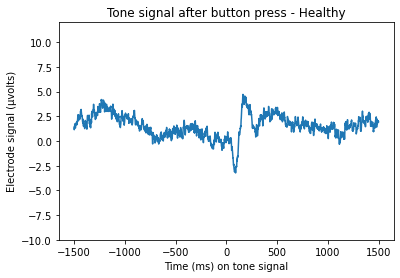

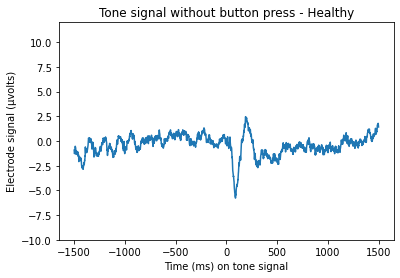

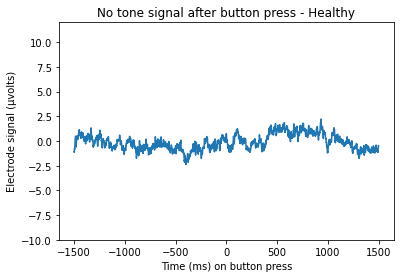

In [11]:
plot_eeg(2)

In [12]:
demographic = demographic[demographic.subject == 2]

NameError: name 'demographic' is not defined

Upper plots show the electrode signal of a healthy, male individual of 39 years and normal education. An amplitude shortly after the signal tone can be seen.

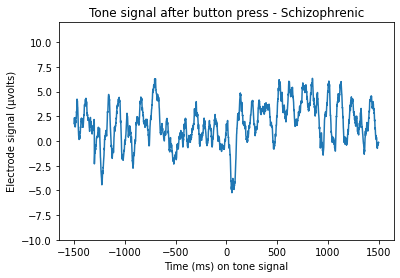

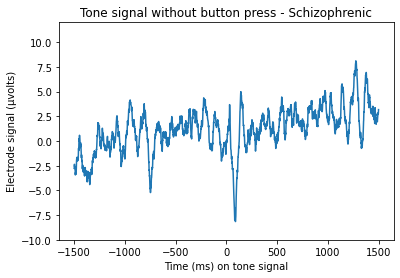

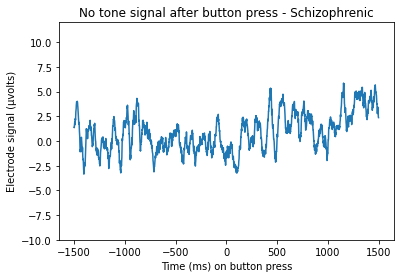

In [13]:
plot_eeg(79)

In [ ]:
demographic[demographic.subject == 79]

Upper plots show the electrode signal of a schizphrenia affected, male individual of 37 years and normal education. The amplitude shortly after the signal tone is not as clear and the brainwave in general is more erratic. 

In [14]:
electrodes_list = list(pd.read_csv("C:/All DataSet/Schizophrenia/archivecolumnLabels.csv").columns[4:])
print(electrodes_list)

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'VEOa', 'VEOb', 'HEOL', 'HEOR', 'Nose', 'TP10']


In [15]:
len(electrodes_list)

70

## **Downsampling**

There are 81 subjects to analyze. Each subject had to complete each of the 3 button/tone scenarios 100 times (100x button press with tone after, 100x tone signal without button being pushed, 100x button press with no tone signal after) and for each of the 300 trials, up to 3,072 samples of each electrode were collected. The data was collected for 70 electrodes, so this results in 81 datasets of each roughly 64.5 million values (3 * 100 * 3,072 * 70), if all samples were collected, which is not always the case. Still, this is too much data to process, so simplifying the data before training is inevitable. To downsize the data a little bit, the average of N samples of each electrode can be calculated.

In [16]:
# Function to calculate the average of N values of every electrode for each trial. This step reduces the dimension of the input data by factor N.

def averaged_by_N_rows(a, n):
    shape = a.shape
    assert len(shape) == 2
    assert shape[0] % n == 0
    b = a.reshape(shape[0] // n, n, shape[1])
    mean_vec = b.mean(axis=1)
    return mean_vec

In [20]:
# The number that the number of maximum samples of 9,216 is divided by
N_AVERAGED = 16

# Empty matrices of 0s in the required dimensions are built:
# 81 = no. of subjects
# 100 = no. of trials (100 trials per subject)
# 9,216 = 3 button press/tone scenarios * 3,072 EEG samples
# electrodes_list = 70
X = np.zeros((81 * 100,  9216 * len(electrodes_list) // N_AVERAGED), dtype="float32")
Y = np.zeros(len(X))

part1_path = "C:/All DataSet/Schizophrenia/archive/part1"
part2_path = "C:/All DataSet/Schizophrenia/archive/part2"

x_counter = 0
column_list = pd.read_csv("C:/All DataSet/Schizophrenia/archive/columnLabels.csv").columns
for person_number in range(1, 81 + 1):
            
    
    csv_path = f"{part1_path}/{person_number}.csv/{person_number}.csv"
    if not os.path.exists(csv_path):
        csv_path = f"{part2_path}/{person_number}.csv/{person_number}.csv"
    df = pd.read_csv(csv_path, 
                header=None,
                names=column_list
                )

    trials_list = set(df.trial)
    
# For every trial from 1 to 100 of each test subject from 1 to 81, up to 9,216 samples are divided by 16 (in some test subjects' trials there are less than 9,216 samples).
    for t1, trial_number in enumerate(trials_list):
        number_of_trials = len(df[df.trial == trial_number])
        if number_of_trials == 9216.0:
            current_sample_matrix = df[df.trial == trial_number][electrodes_list].values
            averaged_by_N = averaged_by_N_rows(current_sample_matrix, n=N_AVERAGED)
            averaged_by_N_big_vec = averaged_by_N.reshape(-1)
            X[x_counter] = averaged_by_N_big_vec.astype(np.float32)
            Y[x_counter] = diagnosis_dict[person_number]
            x_counter += 1

print("Number of trials - ", x_counter)
X = X[: x_counter]
Y = Y[: x_counter]

Number of trials -  7092


The averaged electrode data was saved as X variable and the corresponding diagnosis was saved to a Y variable. The contained data can be written to a binary format file (for fewer disk space usage).

In [21]:
X.tofile("C:/All DataSet/Schizophrenia/archive/working/goodX_every4.bin")
Y.astype("uint8").tofile("C:/All DataSet/Schizophrenia/archive/working/goodY_every4.bin")

The X and Y binary files have to be converted to NumPy arrays, so that they can be used as an input for CNNs.

In [22]:
Y = np.fromfile("C:/All DataSet/Schizophrenia/archive/working/goodY_every4.bin", dtype=np.uint8)    
X = np.fromfile("C:/All DataSet/Schizophrenia/archive/working/goodX_every4.bin", dtype=np.float32).reshape(len(Y), -1)
print("Done! Time:", time.ctime())

Done! Time: Sat Apr  9 00:55:54 2022


In [23]:
Y = np.fromfile("C:/All DataSet/Schizophrenia/archive/working/goodY_every4.bin", dtype=np.uint8)    
X = np.fromfile("C:/All DataSet/Schizophrenia/archive/working/goodX_every4.bin", dtype=np.float32).reshape(len(Y), -1)
print("Done! Time:", time.ctime())

Done! Time: Sat Apr  9 00:56:16 2022


## **Preprocessing**

Before being used as an input, the electrode values are being normalized because it is recommended to use scaling on CNN input. To do so, the electrode values have to be represented in one dimension and everything else (test subject, trial no., sample no.) has to be put into the other dimension.

In [24]:
X_norm = (normalize(X.reshape(-1, 70), axis=0, norm='max')).reshape(X.shape)

## **Train/Test-Split**

In [25]:
X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(X_norm, Y, test_size=0.2, shuffle=True, random_state=42)

The predictor data is once more reshaped so that the array has three dimensions:
1) each trial of every test subject (81 * 100)
2) electrodes (70)
3) average of every 16th of the 9,216 samples (576)

Not every trial had all the 9,216 samples, so it is expected that there are not all 81 * 100 trials present in the array.

In [26]:
X_train_2d = X_train_norm.reshape(X_train_norm.shape[0], len(electrodes_list), X_train_norm.shape[1] // len(electrodes_list), 1)
X_test_2d = X_test_norm.reshape(X_test_norm.shape[0], len(electrodes_list), X_test_norm.shape[1] // len(electrodes_list), 1)
X_train_2d.shape[0] + X_test_2d.shape[0]

7092

7,092 trials are in the array, so 7,092 "cases" which can be used for training and testing, each labelled as healthy or schizophrenic.

## **Modelling**

### 1st Model

In [27]:
filepath="C:/All DataSet/Schizophrenia/archive/best_model1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 20),
                 activation='tanh',
                 input_shape=(X_train_2d.shape[1:])))
model.add(MaxPooling2D(pool_size=(5, 15)))

model.add(Conv2D(13, kernel_size=(3, 3),
                 activation='tanh',))
model.add(MaxPooling2D(pool_size=(3, 3)))
          

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(317, activation='relu'))

model.add(Dense(1, activation='sigmoid'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam

In [ ]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.00001),
              metrics=['acc'])

In [37]:
model.compile(optimizer= 'adam' , 
              loss= keras.losses.binary_crossentropy,
              metrics=['acc'])

In [38]:
history_params = []

In [39]:
history = model.fit(X_train_2d, Y_train_norm,
          batch_size=17,
          epochs=100,
          verbose=1,
          shuffle=True,
          validation_data=(X_test_2d, Y_test_norm), callbacks=[checkpoint])




Train on 5673 samples, validate on 1419 samples
Epoch 1/100





5673/5673 [==============================] - 15s 3ms/step - loss: 0.6647 - acc: 0.5976 - val_loss: 0.6566 - val_acc: 0.5927

Epoch 00001: val_acc improved from -inf to 0.59267, saving model to C:/All DataSet/Schizophrenia/archive/best_model1.h5
Epoch 2/100
5673/5673 [==============================] - 4s 680us/step - loss: 0.6505 - acc: 0.6067 - val_loss: 0.6512 - val_acc: 0.6180

Epoch 00002: val_acc improved from 0.59267 to 0.61804, saving model to C:/All DataSet/Schizophrenia/archive/best_model1.h5
Epoch 3/100
5673/5673 [==============================] - 4s 680us/step - loss: 0.6410 - acc: 0.6078 - val_loss: 0.6521 - val_acc: 0.6117

Epoch 00003: val_acc did not improve from 0.61804
Epoch 4/100
5673/5673 [==============================] - 4s 685us/step - loss: 0.6313 - acc: 0.6226 - val_loss: 0.6315 - val_acc: 0.6279

Epoch 00004: val_acc improved from 0.61804 to 0.62791, saving model to C:/All DataSet/Schizophrenia/

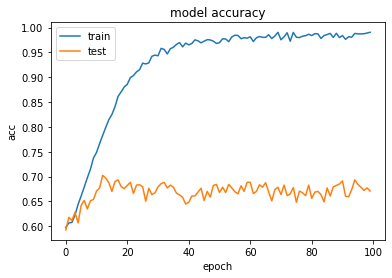

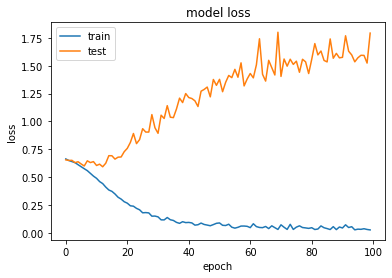

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The model seems to underfit. Test accuracy increases well till the 40th epoch but then starts to stagger, whereas the accuracy on the training data continues to improve. The model loss decreases gradually both for training and test data, meaning that further training might minimize loss further.

In [41]:
accuracy, loss = model.evaluate(X_test_2d, Y_test_norm)
print(f"Val accuracy={accuracy}  val loss={loss}")

1419/1419 [==============================] - 0s 347us/step
Val accuracy=1.7916231052904081  val loss=0.6708949963923825


In [42]:
y_predicted =  model.predict(X_test_2d)

confusion_matr = confusion_matrix(Y_test_norm, np.round(model.predict(X_test_2d)))
confusion_matr

array([[358, 220],
       [247, 594]], dtype=int64)

In [43]:
print(
  "True negative control(0): ", confusion_matr[0, 0], "\n",
  "False negative control(0):", confusion_matr[0, 1], "\n",
  "False positive schizophrenic(1):", confusion_matr[1, 0], "\n",
  "True positive schizophrenic(1):", confusion_matr[1, 1], "\n"    
)

True negative control(0):  358 
 False negative control(0): 220 
 False positive schizophrenic(1): 247 
 True positive schizophrenic(1): 594 



In [44]:
TN = confusion_matr[0, 0]
FN = confusion_matr[0, 1]
FP = confusion_matr[1, 0]
TP = confusion_matr[1, 1]
TP, FP, FN, TN

(594, 247, 220, 358)

In [45]:
sensitivity = TP / (TP + FN)
sensitivity

0.7297297297297297

In [46]:
specificity = TN / (TN + FP)
specificity

0.5917355371900826

### **Model 1**

Accuracy: **67.08%** <br>
Sensitivity: **72.97%** <br>
Specificity: **59.2%** <br>

The first model classifies 67.08% of the trials correctly. Sensitivity and specificity lie around 72.97% and 59.2%, meaning that the model is not very accurate yet and performs slightly better than guessing randomly. The reason for this is that the model could not learn the predicting patterns correctly and could not depict the complexity behind the differences in the brainwave data of schizophrenic and healthy subjects.